In [1]:
from typing import Dict
from IPython import display
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from copy import deepcopy

import seaborn as sns
sns.set_theme()

from src.deep_hedging.DeepHedge import DeepHedgeConfig, DeepHedge
from src.deep_hedging.DeepHedgeHeston import DeepHedgeHeston, DeepHedgeHestonConfig
from src.deep_hedging.DeepHedgeTrainer import DeepHedgeTrainer, DeepHedgeTrainerConfig
from src.deep_hedging.StrategyNet import StrategyNetConfig
from src.deep_hedging.objectives.HedgeObjective import MeanVariance, Entropy, StableEntropy, Std
from src.derivative.EuropeanCallOption import EuropeanCallOption
from src.gan.RobustDhGan import RobustDhGan
from src.generator.HestonCoefficient import HestonCoefficientConfig, HestonDriftCoefficient, HestonDiffusionCoefficient
from src.generator.SdeGenerator import GeneratorConfig, SdeGenerator
from src.generator.HestonGenerator import HestonGenerator as TrainableHestonGenerator
from src.generator.SdeGeneratorTrainer import SdeGeneratorTrainerConfig
from src.penalty.Augmentations import LeadLag, AddTimeComponent
from src.penalty.SigWassersteinMetric import SignatureConfig, SigWassersteinMetric
from src.util.TimeUtil import UniformTimeDiscretization
from src.util.processes.BlackScholesGenerator import BlackScholesGenerator
from src.util.processes.BrownianMotionGenerator import BrownianMotionGenerator
from src.util.processes.HestonGenerator import HestonParameterSet, HestonGenerator
from src.util.torch_util.AdapterUtil import Adapter, AdapterList, SelectDimensions, ConvertToIncrements
from src.util.torch_util.TrainingUtil import TrainerConfig
from src.generator.SdeGeneratorTrainer import SdeGeneratorTrainer
from src.util.torch_util.CallbackUtil import PrintMetrics, PrintGeneratorParameters, PrintEmptyLine
from src.util.VisualizationUtil import QuantityLogger
from src.util.torch_util.TrainingUtil import TrainerConfig, PbarOption, gen_factory
from src.util.ray_util.TqdmUtil import to_limited_iterator, to_iterator
from src.util.PushOverUtil import notify
from src.config import DEVICE

In [2]:
import ray
ray.init()

2023-04-14 18:17:39,955	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.8.0
Ray version:,2.0.1


In [3]:
trading_freq: int = 5
penalty_scale: float = 20000
uncertainty_aversion: float = 130

In [4]:
target_folder = f'resources/network-states/test_h_alt/ua{uncertainty_aversion:03}/tf_{trading_freq:02}'
add_on = f'/v_sigw_{penalty_scale:05.0f}'
target_folder+add_on

'resources/network-states/test_h_alt/ua130/tf_05/v_sigw_20000'

## Setup

In [5]:
heston_parameters = HestonParameterSet(
    drift=0.0,
    reversion_level=0.04,
    reversion_speed=1,
    vol_of_vol=0.2,
    correlation=-.8,
)
estimated_model = HestonGenerator(parameter=heston_parameters)

In [6]:
td = UniformTimeDiscretization(trading_freq * 1. / 255., 90 // trading_freq)
derivative = EuropeanCallOption(strike=1.0, time_discretization=td, price=0.0)

In [7]:
estimated_generator = estimated_model.provide_generator(
    initial_value=np.array([1.0, heston_parameters.reversion_level]),
    times=td.times,
    random_number_generator=np.random.default_rng(123456),
)
reference_paths = estimated_generator(2**16)

In [8]:
pen_config = SignatureConfig(depth=2, augmentations=[AddTimeComponent(td), LeadLag()])
penalizer = SigWassersteinMetric(reference_paths[:, :, 0:2], pen_config, transform=lambda x: penalty_scale * x)

## Generator

In [9]:
coef_config = HestonCoefficientConfig(heston_parameters, initial_asset_price=1.0)
drift_coef, diffusion_coef = HestonDriftCoefficient(coef_config), HestonDiffusionCoefficient(coef_config)
gen_config = GeneratorConfig(td, drift_coef.get_initial_asset_price, drift_coef, diffusion_coef)
generator = TrainableHestonGenerator(generator_config=gen_config)

In [10]:
generator.drift._drift.requires_grad = False

In [11]:
noise_generator = BrownianMotionGenerator().provide_increment_generator(
    initial_value=np.zeros(2),
    times=td.times,
    random_number_generator=np.random.default_rng(12345),
)

## Deep Hedge

In [12]:
hedge_objective = Entropy(uncertainty_aversion)

In [13]:
deep_hedge = DeepHedgeHeston(
    DeepHedgeHestonConfig(
        derivative=derivative,
        initial_information_value=torch.tensor([
                1.0,
                heston_parameters.reversion_level,
                HestonGenerator(parameter=heston_parameters).get_correction_term(td.maturity, heston_parameters.reversion_level),
            ], dtype=torch.float32, device=DEVICE),
        strategy_config=StrategyNetConfig(
            dim_of_information_process=2,
            dim_of_tradable_asset=2,
            number_of_layers=2,
            nodes_in_intermediate_layers=128,
        ),
    )
)

In [14]:
dh_trainer_config = DeepHedgeTrainerConfig(hedge_objective)
trainer_config = None
dh_trainer = DeepHedgeTrainer(dh=deep_hedge, config=dh_trainer_config, trainer_config=trainer_config)

In [15]:
sample_size = 2**16
batch_sizes_for_epoch = [2**8]*5 + [2**10]*5 + [2**12]*5 + [2**14]*5
to_increments = ConvertToIncrements()

In [16]:
for p in generator.parameters():
    p.requires_grad = False

In [17]:
try: 
    deep_hedge.load_state_dict(torch.load(f'{target_folder}/deep_hedge.pt'))
    dh_trainer.optimizer.load_state_dict(torch.load(f'{target_folder}/deep_hedge_optimizer.pt'))
except FileNotFoundError:
    m_list = []
    for batch_size in tqdm(batch_sizes_for_epoch):
        data = to_increments(generator(noise_generator(sample_size)))
        for batch in tqdm(torch.split(data, split_size_or_sections=batch_size, dim=0), leave=False):
            m_list.append(dh_trainer.step(batch))
    
    torch.save(deep_hedge.state_dict(), f'{target_folder}/deep_hedge.pt') 
    torch.save(dh_trainer.optimizer.state_dict(), f'{target_folder}/deep_hedge_optimizer.pt')
    
    np.save(f'{target_folder}/deep_hedge_training_metrics.npy', np.array([m.create_print_dict() for m in m_list])),

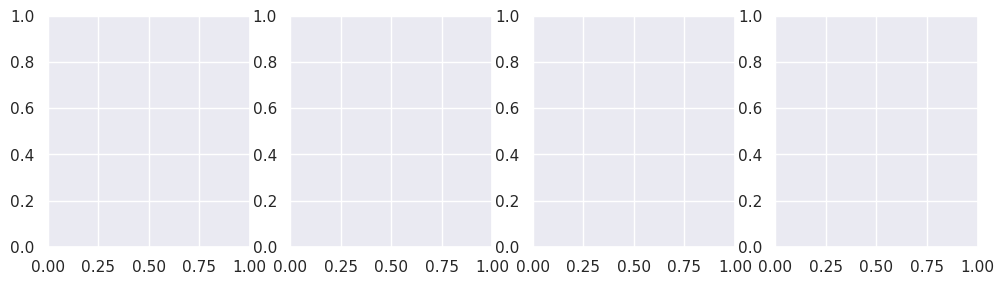

In [18]:
try:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    for ax, beg in zip(axs, np.cumsum((0, 5*2**8, 5*2**6, 5*2**4))):
        ax.plot(np.log([m.hedge_loss.item() for m in m_list][beg:]))
    plt.tight_layout()
    plt.show()
except:
    pass

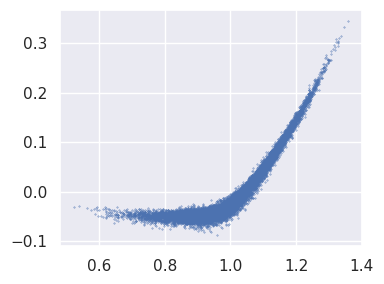

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
test_data = torch.diff(estimated_generator(2**14), 1, 1)
deep_hedge.eval()
deep_hedge_results = np.sum(deep_hedge(test_data).cpu().detach().numpy() * test_data.cpu().numpy()[:, :, (0,2)], axis=(1))
terminal_values_on_test = np.sum(test_data.cpu().numpy(), axis=(1))[:, 0] + 1.0
ax.scatter(terminal_values_on_test, np.sum(deep_hedge_results, axis=1), s=.1)
deep_hedge.train()
plt.tight_layout()
plt.show()

## Roubst Hedge GAN

In [20]:
active_generator = deepcopy(generator)
for p in active_generator.parameters():
    p.requires_grad = True

In [21]:
dht_config = DeepHedgeTrainerConfig(
    hedge_objective=hedge_objective,
    generation_adapters=AdapterList([ConvertToIncrements()]),
)
gt_config = SdeGeneratorTrainerConfig(
    penalizer=penalizer,
    penalization_adapters=AdapterList([SelectDimensions(slice(0,2,1))]),
)
t_config = None
robust_dh_gan = RobustDhGan(
    dh=deepcopy(deep_hedge), 
    hedge_config=dht_config,
    gen=active_generator,
    gen_config=gt_config,
    trainer_config=t_config,
)
robust_dh_gan.dh_optimizer.load_state_dict(dh_trainer.optimizer.state_dict())

In [22]:
batch_sizes_for_epoch = 1000*[2**16]

In [23]:
try: 
    # raise FileNotFoundError
    robust_dh_gan.dh.load_state_dict(torch.load(f'{target_folder+add_on}/rhgan_dh.pt'))
except FileNotFoundError:
    m_list = []
    for batch_size in tqdm(batch_sizes_for_epoch):
        data = noise_generator(sample_size)
        for batch in torch.split(data, split_size_or_sections=batch_size, dim=0):
            m_list.append(robust_dh_gan.step(batch))
    
    torch.save(robust_dh_gan.dh.state_dict(), f'{target_folder+add_on}/rhgan_dh.pt') 
    torch.save(robust_dh_gan.dh_optimizer.state_dict(), f'{target_folder+add_on}/rhgan_dh_optimizer.pt')
    torch.save(robust_dh_gan.gen_optimizer.state_dict(), f'{target_folder+add_on}/rhgan_gen_optimizer.pt')
    
    np.save(f'{target_folder+add_on}/rhgan_training_metrics.npy', np.array([m.create_print_dict() for m in m_list])),

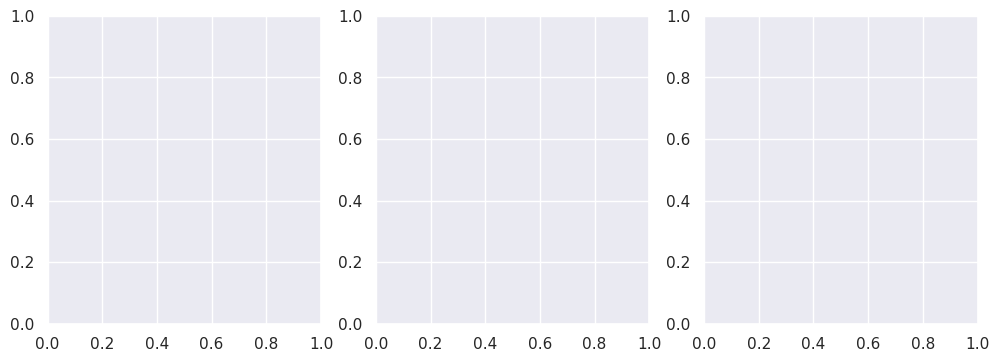

In [24]:
try:
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].plot(np.log([m.hedge_loss.item() for m in m_list]))
    axs[1].plot(-np.log([-m.generation_loss.item() for m in m_list]))
    axs[2].plot(np.log([m.penalty.item() for m in m_list]))
    plt.tight_layout()
    plt.show()
except:
    pass

## Post Deep Hedge Training

In [25]:
try: 
    deep_hedge.load_state_dict(torch.load(f'{target_folder}/deep_hedge_post_trained.pt'))
except FileNotFoundError:
    m_list = []
    for batch_size in tqdm(batch_sizes_for_epoch):
        data = to_increments(generator(noise_generator(sample_size)))
        for batch in torch.split(data, split_size_or_sections=batch_size, dim=0):
            m_list.append(dh_trainer.step(batch))
            
    torch.save(deep_hedge.state_dict(), f'{target_folder}/deep_hedge_post_trained.pt') 
    np.save(f'{target_folder}/deep_hedge_post_trained_training_metrics.npy', np.array([m.create_print_dict() for m in m_list])),

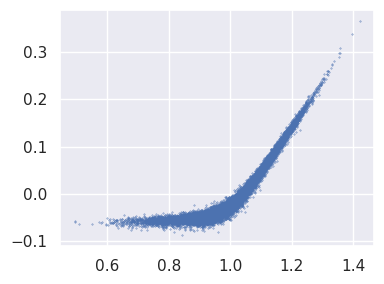

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
test_data = torch.diff(estimated_generator(2**14), 1, 1)
deep_hedge.eval()
robust_dh_gan.dh.eval()
deep_hedge_results = np.sum(deep_hedge(test_data).cpu().detach().numpy() * test_data.cpu().numpy()[:, :, (0,2)], axis=(1))
rhgan_results = np.sum(robust_dh_gan.dh(test_data).cpu().detach().numpy() * test_data.cpu().numpy()[:, :, (0,2)], axis=(1))
terminal_values_on_test = np.sum(test_data.cpu().numpy(), axis=(1))[:, 0] + 1.0
ax.scatter(terminal_values_on_test, np.sum(rhgan_results, axis=1), s=.1) # - np.sum(deep_hedge_results, axis=1)
deep_hedge.train()
robust_dh_gan.dh.train()
plt.tight_layout()
plt.show()

# OOSP

In [27]:
pars_f = 'resources/uncertainty-test-sets/heston/next_parameters_clean.npy'
pars_coarseness = 0
pars = np.load(pars_f, allow_pickle=True)
par_sets = [HestonParameterSet(
    drift=0.0,
    reversion_level=d[0],
    reversion_speed=d[1],
    vol_of_vol=d[2],
    correlation=d[3],
) for d in pars]

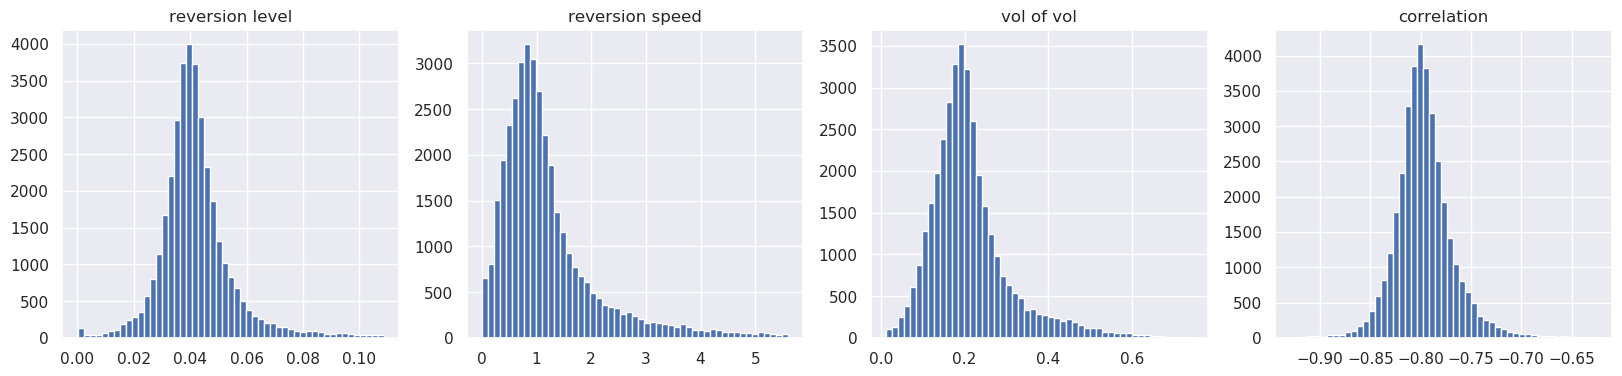

In [28]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))

axs[0].hist([par_set.reversion_level for par_set in par_sets], bins=51)
axs[0].set_title('reversion level')

axs[1].hist([par_set.reversion_speed for par_set in par_sets], bins=51)
axs[1].set_title('reversion speed')

axs[2].hist([par_set.vol_of_vol for par_set in par_sets], bins=51)
axs[2].set_title('vol of vol')

axs[3].hist([par_set.correlation for par_set in par_sets], bins=51)
axs[3].set_title('correlation')
plt.show()

In [29]:
test_generators = [
    HestonGenerator(parameter=ps).provide_generator(
        initial_value=np.array([1.0, ps.reversion_level]),
        times=td.times,
        random_number_generator=np.random.default_rng(8888 + i),
        device='cpu',
    ) for i, ps in enumerate(par_sets)
]

In [30]:
test_data = torch.diff(torch.cat([tg(1) for tg in tqdm(test_generators)]), 1, 1)

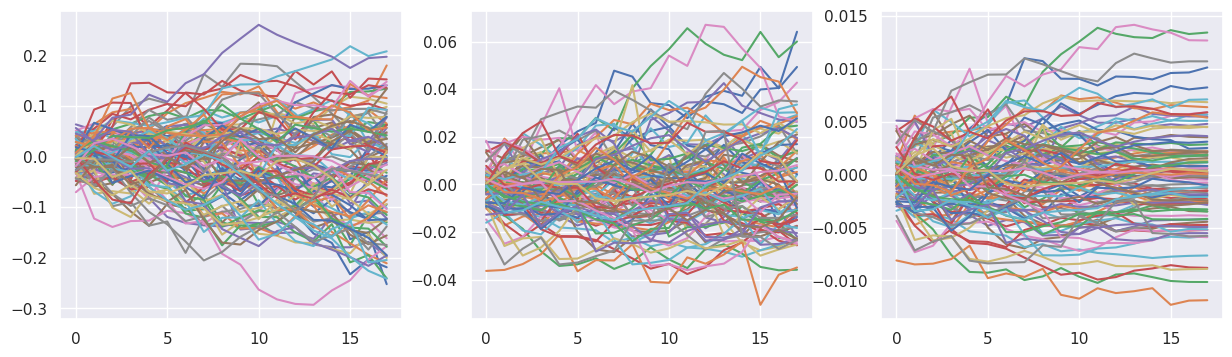

In [31]:
f, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axs):
    ax.plot(np.cumsum(test_data.numpy()[:100, :, i], axis=1).T)
plt.show()

## Optimal Hedge on OOSP-data

In [32]:
optimal_hedge = deepcopy(deep_hedge)

In [33]:
batch_sizes_for_epoch = 500*[10000]#[2**15]
to_increments = ConvertToIncrements()

In [34]:
oh_trainer_config = DeepHedgeTrainerConfig(hedge_objective)
trainer_config = None
oh_trainer = DeepHedgeTrainer(dh=optimal_hedge, config=oh_trainer_config, trainer_config=trainer_config)
oh_trainer.optimizer.load_state_dict(dh_trainer.optimizer.state_dict())

In [35]:
version = '4'
try: 
    optimal_hedge.load_state_dict(torch.load(f'{target_folder}/optimal_hedge_pc{pars_coarseness}{version}.pt'))
except FileNotFoundError:
    m_list = []
    data = test_data[:10000].cuda()
    for batch_size in tqdm(batch_sizes_for_epoch):
        for batch in torch.split(data, split_size_or_sections=batch_size, dim=0):
            m_list.append(oh_trainer.step(batch))
            
    torch.save(optimal_hedge.state_dict(), f'{target_folder}/optimal_hedge_pc{pars_coarseness}{version}.pt') 
    np.save(f'{target_folder}/optimal_hedge_pc{pars_coarseness}_training_metrics.npy', np.array([m.create_print_dict() for m in m_list])),

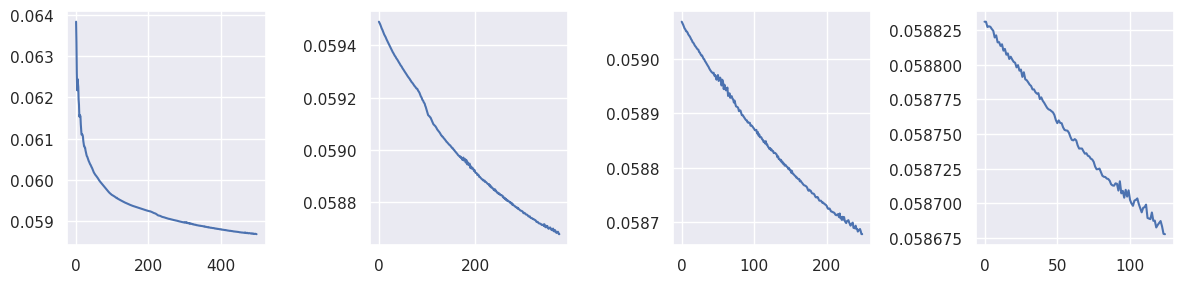

In [36]:
try:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    for ax, beg in zip(axs, (0, 125, 250, 375)):
        ax.plot(([m.hedge_loss.item() for m in m_list][beg:]))
    plt.tight_layout()
    plt.show()
except:
    pass

## Evaluation

In [37]:
terminal_values_on_oos_test_set = np.sum(test_data.numpy(), axis=(1))[:, 0] + 1.0

In [38]:
dh_oosp = hedge_objective(deep_hedge(test_data[:2**15].cuda())).cpu().item()
rhgan_oosp = hedge_objective(robust_dh_gan.dh(test_data[:2**15].cuda())).cpu().item()
optimal_oosp = hedge_objective(optimal_hedge(test_data[:2**15].cuda())).cpu().item()

In [39]:
print(f'Optimal:          {optimal_oosp:.6f}')
print(f'Deep Hedge:       {dh_oosp:.6f}')
print(f'Robust Hedge GAN: {rhgan_oosp:.6f}')
print(f'--> improved by : {100*(1-rhgan_oosp/dh_oosp):.4f}%')

Optimal:          0.088049
Deep Hedge:       0.087270
Robust Hedge GAN: 0.076813
--> improved by : 11.9829%


In [40]:
no_to_display = 10000

In [41]:
@ray.remote
def generate(index, gen, number_of_paths):
    return index, gen(number_of_paths)

In [42]:
dh_oosp_for_ps_dict = {}
oh_oosp_for_ps_dict = {}
rhgan_oosp_for_ps_dict = {}
distances_to_estimate_dict = {}
for indices in tqdm(np.array_split(np.arange(no_to_display), np.arange(48,no_to_display,48))):
    for i, paths in ray.get([generate.remote(index=i, gen=test_generators[i], number_of_paths=no_to_display) for i in indices]):
        paths = paths.cuda()
        increments = torch.diff(paths, 1, 1)
        dh_oosp_for_ps_dict[i] = hedge_objective(deep_hedge(increments)).cpu().item()
        oh_oosp_for_ps_dict[i] = hedge_objective(optimal_hedge(increments)).cpu().item()
        rhgan_oosp_for_ps_dict[i] = hedge_objective(robust_dh_gan.dh(increments)).cpu().item() 
        distances_to_estimate_dict[i] = penalizer(paths[:, :, 0:2]).item()

In [43]:
dh_oosp_for_ps = [dh_oosp_for_ps_dict[i] for i in range(no_to_display)]
oh_oosp_for_ps = [oh_oosp_for_ps_dict[i] for i in range(no_to_display)]
rhgan_oosp_for_ps = [rhgan_oosp_for_ps_dict[i] for i in range(no_to_display)]
distances_to_estimate = [distances_to_estimate_dict[i] for i in range(no_to_display)]

In [44]:
print(f'                   Mean:       Std:')
print(f'Opt. Hedge:        {np.mean(oh_oosp_for_ps):.6f}    {np.std(oh_oosp_for_ps):.6f}')
print(f'Deep Hedge:        {np.mean(dh_oosp_for_ps):.6f}    {np.std(dh_oosp_for_ps):.6f}')
print(f'Robust Hedge GAN:  {np.mean(rhgan_oosp_for_ps):.6f}    {np.std(rhgan_oosp_for_ps):.6f}')

                   Mean:       Std:
Opt. Hedge:        0.055808    0.009992
Deep Hedge:        0.055469    0.011308
Robust Hedge GAN:  0.054939    0.009578


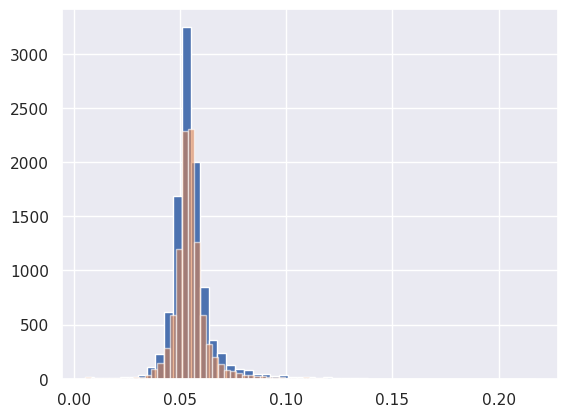

In [45]:
plt.hist(dh_oosp_for_ps, bins=51)
plt.hist(rhgan_oosp_for_ps, bins=51, alpha=.6)
plt.show()

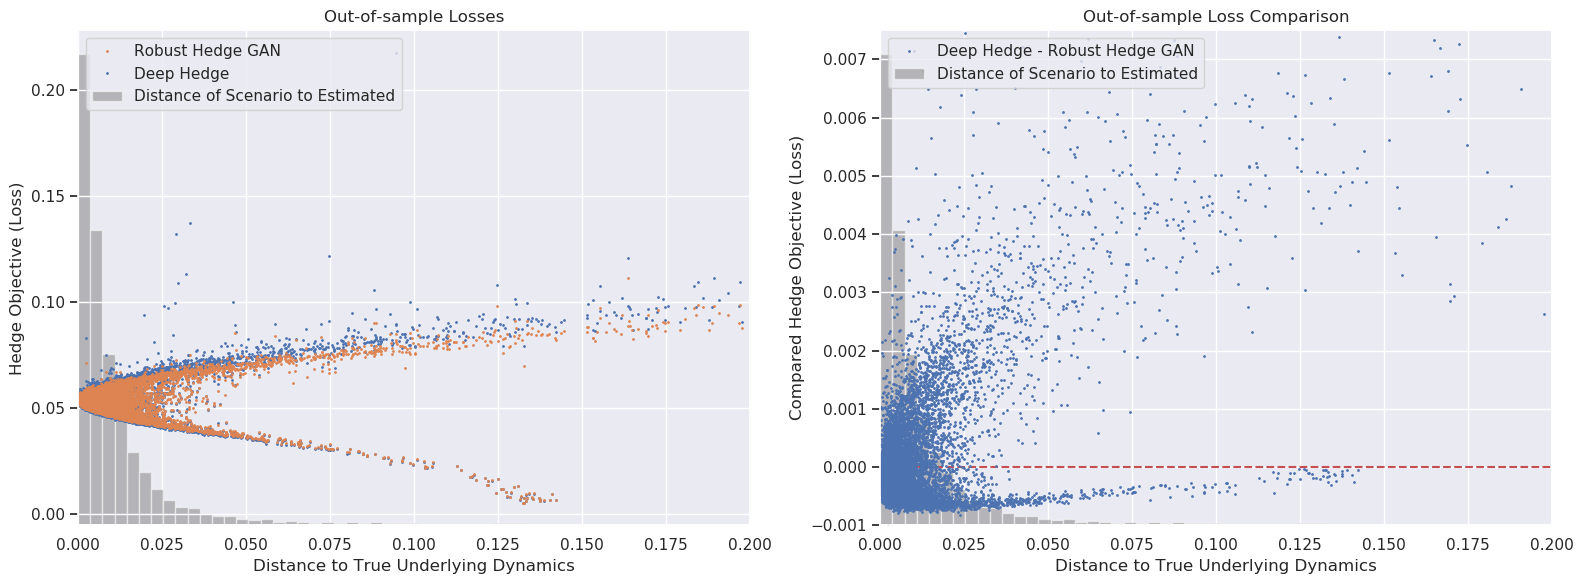

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for_plot = 10000

ax0 = axs[0].twinx()
axs[0].grid(axis='y')
axs[0].hist(distances_to_estimate[:no_to_display], bins=151, alpha=.5, color='grey', label='Distance of Scenario to Estimated')
axs[0].get_yaxis().set_ticks([])
ax0.plot(distances_to_estimate[:for_plot], np.array(dh_oosp_for_ps)[:for_plot], ls='', marker='.', label='Deep Hedge', ms=2)
ax0.plot(distances_to_estimate[:for_plot], np.array(rhgan_oosp_for_ps)[:for_plot], ls='', marker='.', label='Robust Hedge GAN', ms=2)
axs[0].set_xlabel('Distance to True Underlying Dynamics')
ax0.set_ylabel('Hedge Objective (Loss)')
ax0.set_title('Out-of-sample Losses')
ax0.yaxis.tick_left()
ax0.yaxis.set_label_position("left")
# ax0.set_yscale('log')
lines, labels = ax0.get_legend_handles_labels()
lines2, labels2 = axs[0].get_legend_handles_labels()
ax0.set_xlim((0.0, 0.2))
ax0.legend(lines[1:] + lines[:1] + lines2, labels[1:] + labels[:1] + labels2, loc=2)

ax1 = axs[1].twinx()
axs[1].grid(axis='y')
axs[1].hist(distances_to_estimate[:no_to_display], bins=151, alpha=.5, color='grey', label='Distance of Scenario to Estimated')
axs[1].get_yaxis().set_ticks([])
ax1.axhline(0.0, c='C3', ls='--')
ax1.plot(distances_to_estimate[:for_plot], np.array(dh_oosp_for_ps)[:for_plot] - np.array(rhgan_oosp_for_ps)[:for_plot], ls='', marker='.', ms=2, label='Deep Hedge - Robust Hedge GAN')
axs[1].set_xlabel('Distance to True Underlying Dynamics')
ax1.set_ylabel('Compared Hedge Objective (Loss)')
ax1.set_title('Out-of-sample Loss Comparison')
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = axs[1].get_legend_handles_labels()
ax1.set_xlim((0.0, 0.2))
ax1.set_ylim((-.001, 0.0075))
ax1.legend(list(reversed(lines)) + lines2, list(reversed(labels)) + labels2, loc=2)

plt.tight_layout()
plt.savefig(f'figs/oosp_h/tf{trading_freq:02}_ps{penalty_scale:.0f}_pc{pars_coarseness}_ua{uncertainty_aversion:03}.pdf')
plt.show()

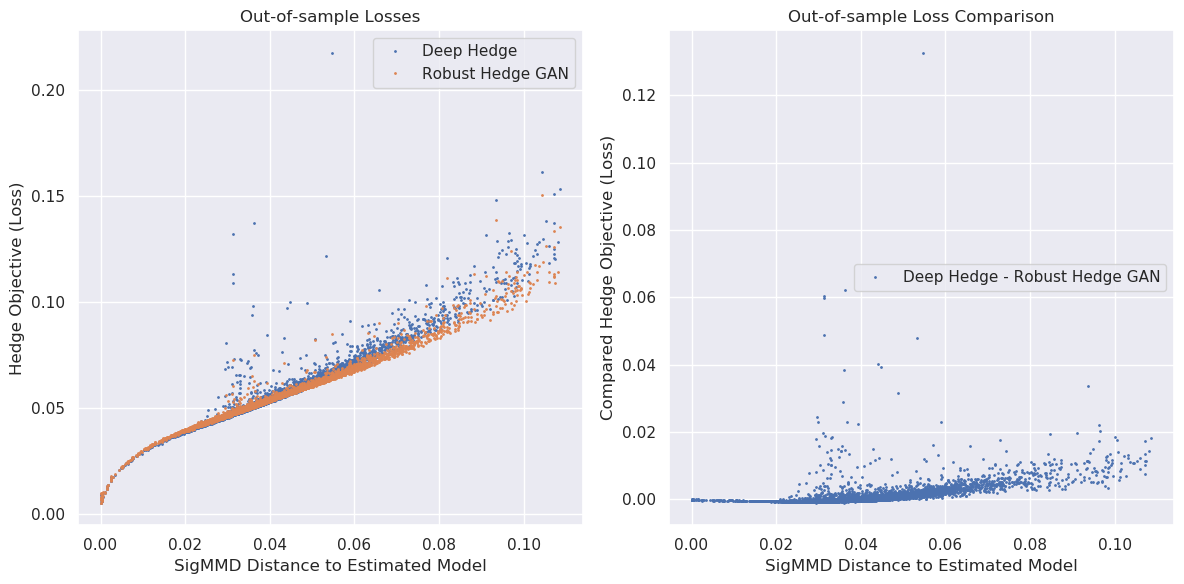

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot([d.reversion_level for d in par_sets[:no_to_display]], np.array(dh_oosp_for_ps), ls='', marker='.', label='Deep Hedge', ms=2)
axs[0].plot([d.reversion_level for d in par_sets[:no_to_display]], np.array(rhgan_oosp_for_ps), ls='', marker='.', label='Robust Hedge GAN', ms=2)
axs[0].set_xlabel('SigMMD Distance to Estimated Model')
axs[0].set_ylabel('Hedge Objective (Loss)')
axs[0].set_title('Out-of-sample Losses')
axs[0].legend()

axs[1].plot([d.reversion_level for d in par_sets[:no_to_display]], np.array(dh_oosp_for_ps) - np.array(rhgan_oosp_for_ps), ls='', marker='.', ms=2, label='Deep Hedge - Robust Hedge GAN')
axs[1].set_xlabel('SigMMD Distance to Estimated Model')
axs[1].set_ylabel('Compared Hedge Objective (Loss)')
axs[1].set_title('Out-of-sample Loss Comparison')
axs[1].legend()
plt.tight_layout()
# plt.savefig(f'figs/oosp_h/tf{trading_freq:02}_ps{penalty_scale:.0f}_pc{pars_coarseness}_ua{uncertainty_aversion:03}.pdf')
plt.show()